In [2]:
import os
import json
import numpy as np
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def calculate_non_background_ratio(image_patch):
    non_background_count = np.sum(image_patch != 0)
    
    total_pixels = image_patch.size
    
    non_background_ratio = (non_background_count / total_pixels) * 100
    
    return non_background_ratio

In [3]:
def extract_patches(image, crop_size, stride, padding):
    patches = []
    padded_image = np.pad(image, padding, mode='constant', constant_values=0)
    
    H, W = crop_size
    for y in range(0, padded_image.shape[0] - H + 1, stride):
        for x in range(0, padded_image.shape[1] - W + 1, stride):
            patch = padded_image[y:y + H, x:x + W]
            patches.append((patch, (x, y)))
    
    return patches

In [4]:
def process_fold(fold_path, crop_size, stride, padding):
    fold_data = {}
    
    for image_name in os.listdir(fold_path):
        image_path = os.path.join(fold_path, image_name)
        if os.path.isfile(image_path):
            image = Image.open(image_path)
            image_array = np.array(image)
            
            patches = extract_patches(image_array, crop_size, stride, padding)
            patch_ratios = []
            for patch, (x, y) in patches:
                ratio = calculate_non_background_ratio(patch)
                patch_ratios.append({
                    "coordinates": {"x": x, "y": y},
                    "ratio": ratio
                })
            
            fold_data[image_name] = {
                "num_patches": len(patch_ratios),
                "patch_ratios": patch_ratios
            }
    
    return fold_data

In [5]:
def process_directory(dir_path, dataset_name, crop_size=(128, 128), stride=64, padding=0):
    dataset_info = {
        "id": os.path.basename(dir_path),
        "dataset_name": dataset_name,
        "folds": {}
    }
    
    for fold_name in os.listdir(dir_path):
        fold_path = os.path.join(dir_path, fold_name)
        if os.path.isdir(fold_path):
            fold_data = process_fold(fold_path, crop_size, stride, padding)
            dataset_info["folds"][fold_name] = fold_data
    
    return dataset_info

In [6]:
def save_to_json(data, output_path):
    with open(output_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)

In [24]:
def pad_image_to_fixed_size(image, target_size):
    original_H, original_W = image.size
    target_H, target_W = target_size
    
    # No padding if the image already has desired dimensions or above
    if original_H >= target_H and original_W >= target_W:
        return image
    
    pad_H = max((target_H - original_H) // 2, 0)
    pad_W = max((target_W - original_W) // 2, 0)
    
    padded_image = Image.new("L", (target_W, target_H), color=0)

    padded_image.paste(image, (pad_W, pad_H))

    return padded_image

In [28]:
def print_image_sizes_and_calculate_patches_fixed(dir_path, crop_size=(224, 224), stride=16, target_size=(512, 512)):
    for i, image_name in enumerate(os.listdir(dir_path)):
        
        image_path = os.path.join(dir_path, image_name)
        if os.path.isfile(image_path):
            image = Image.open(image_path)
            
            padded_image = pad_image_to_fixed_size(image, target_size)
            padded_array = np.array(padded_image)
            H, W = padded_array.shape[:2]
            
            print(f"Image: {image_name} - Size after padding: {H}x{W}")
            
            num_patches_H = (H - crop_size[0]) // stride + 1
            num_patches_W = (W - crop_size[1]) // stride + 1
            total_patches = num_patches_H * num_patches_W
            
            print(f"Number of patches that would be extracted: {total_patches} "
                  f"({num_patches_H} patches along height, {num_patches_W} patches along width)")
            
            if i == 1:
                visualize_image_with_padding(image_path, target_size)


In [29]:
def visualize_image_with_padding(image_path, target_size):
    """
    Visualise une image avec padding appliqué pour atteindre la taille cible.
    
    Args:
        image_path (str): Chemin vers l'image d'origine.
        target_size (tuple): La taille cible (H, W).
    """
    image = Image.open(image_path)
    H, W = image.size
    padded_image = pad_image_to_fixed_size(image, target_size)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f"Original Image initially: H{H} x W{W}")
    axes[0].axis('off')
    
    axes[1].imshow(padded_image, cmap='gray')
    axes[1].set_title(f"Padded Image to {target_size[0]}x{target_size[1]}")
    axes[1].axis('off')
    
    plt.show()

Image: cju5f0dezct4q08183ydw11dx.jpg - Size after padding: 546x626
Number of patches that would be extracted: 2091 (41 patches along height, 51 patches along width)
Image: cju1fmsyf6gxb0801cimx2gle.jpg - Size after padding: 531x570
Number of patches that would be extracted: 1716 (39 patches along height, 44 patches along width)


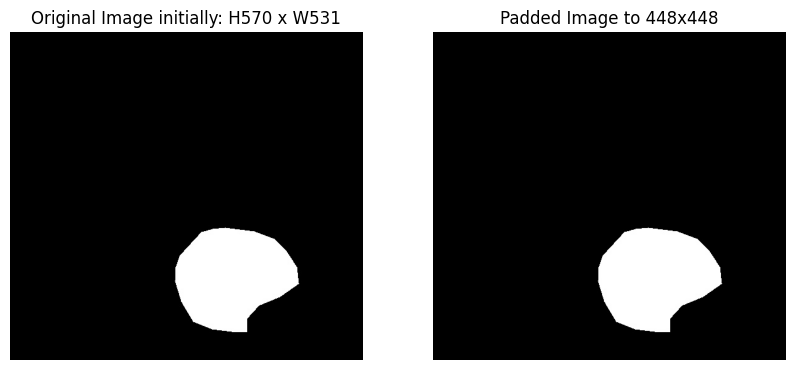

Image: cju2trbpkv0c00988hxla5dzz.jpg - Size after padding: 531x610
Number of patches that would be extracted: 1911 (39 patches along height, 49 patches along width)
Image: cju15l5ubz9yh0855b3ivdpse.jpg - Size after padding: 547x626
Number of patches that would be extracted: 2091 (41 patches along height, 51 patches along width)
Image: cju30xqmh0ni00835ix3batv1.jpg - Size after padding: 529x622
Number of patches that would be extracted: 1950 (39 patches along height, 50 patches along width)
Image: cju1efbr0rqxz09931z0lf4vf.jpg - Size after padding: 529x622
Number of patches that would be extracted: 1950 (39 patches along height, 50 patches along width)
Image: cju2sggy13na70855tbeoqgha.jpg - Size after padding: 530x559
Number of patches that would be extracted: 1638 (39 patches along height, 42 patches along width)
Image: cju5nxkujgscq0817l9gss626.jpg - Size after padding: 531x570
Number of patches that would be extracted: 1716 (39 patches along height, 44 patches along width)
Image: cju

In [30]:
dir_path = '/home/rob/Documents/3_projects/bench/kvasir/masks'
dataset_name = 'kvasir'
crop_size = (224, 224)  
stride = 8 
target_size = (448, 448)
padding = 0

test_fold_path = os.path.join(dir_path, 'fold_0')
print_image_sizes_and_calculate_patches_fixed(test_fold_path, crop_size, stride, target_size)

In [7]:
def pad_image_to_fixed_size(image, target_size):
    original_H, original_W = image.size
    target_H, target_W = target_size
    
    if original_H >= target_H and original_W >= target_W:
        return image.resize(target_size)
    
    pad_H = max((target_H - original_H) // 2, 0)
    pad_W = max((target_W - original_W) // 2, 0)
    
    padded_image = Image.new("L", (target_W, target_H), color=0)
    padded_image.paste(image, (pad_W, pad_H))

    return padded_image

In [8]:
def calculate_non_background_ratio(image_patch):
    return np.sum(image_patch != 0) / image_patch.size

In [9]:
def extract_ratios_for_image(image, crop_size, stride):
    H, W = image.shape
    patch_ratios = []
    
    for y in range(0, H - crop_size[0] + 1, stride):
        for x in range(0, W - crop_size[1] + 1, stride):
            patch = image[y:y + crop_size[0], x:x + crop_size[1]]
            ratio = calculate_non_background_ratio(patch)
            patch_ratios.append(ratio)
    
    return patch_ratios

In [14]:
def save_patch_ratios_fixed_size(dir_path, crop_size, stride, target_size, save_path):
    image_paths = []
    all_ratios = []
    
    for fold_name in os.listdir(dir_path):
        fold_path = os.path.join(dir_path, fold_name)
        if os.path.isdir(fold_path):
            for image_name in os.listdir(fold_path):
                image_path = os.path.join(fold_path, image_name)
                if os.path.isfile(image_path):
                    image = Image.open(image_path).convert('L')
                    
                    # Resize / pad the image
                    padded_image = pad_image_to_fixed_size(image, target_size)
                    padded_array = np.array(padded_image)
                    
                    # Extraire les ratios
                    ratios = extract_ratios_for_image(padded_array, crop_size, stride)
                    
                    image_paths.append(image_path)
                    all_ratios.append(ratios)
    
    np.savez_compressed(save_path, image_paths=image_paths, ratios=np.array(all_ratios))


In [15]:
dir_path = '/home/rob/Documents/3_projects/bench/kvasir/masks'
dataset_name = 'kvasir'
crop_size = (224, 224)  
target_size = (448, 448)
stride = 16

save_path = 'patch_ratios_fixed.npz'

save_patch_ratios_fixed_size(dir_path, crop_size, stride, target_size, save_path)

In [17]:
def inspect_npz_file(npz_file):
    data = np.load(npz_file, allow_pickle=True)
    
    print("Keys in the .npz file:")
    for key in data.keys():
        print(key)
    
    patch_counts = {}
    
    for key in data.keys():
        if key.endswith('_coords'):
            image_name = key.replace('_coords', '')
            num_patches = len(data[key])
            patch_counts[image_name] = num_patches
    
    return patch_counts

def display_patch_counts(patch_counts):
    for image_name, count in patch_counts.items():
        print(f"Image: {image_name}, Number of patches: {count}")

npz_file = 'patch_ratios_fixed.npz'

patch_counts = inspect_npz_file(npz_file)

display_patch_counts(patch_counts)

Keys in the .npz file:
image_paths
ratios


In [3]:
def inspect_npz_file(npz_file):
    data = np.load(npz_file, allow_pickle=True)
    
    print("Keys in the .npz file:")
    for key in data.keys():
        print(key)
    
    image_paths = data['image_paths']
    ratios = data['ratios']

    print(f"\nTotal images: {len(image_paths)}")
    for i, img_path in enumerate(image_paths):
        print(f"Image {i}: {img_path}")
        print(f"  Number of patches: {len(ratios[i])}")
        print(f"  Example ratios: {ratios[i][:5]}") 

    return image_paths, ratios

npz_file = 'patch_ratios_fixed.npz'
image_paths, ratios = inspect_npz_file(npz_file)

Keys in the .npz file:
image_paths
ratios

Total images: 1000
Image 0: /home/rob/Documents/3_projects/bench/kvasir/masks/fold_2/cju88gx09o2vk0818610zody3.jpg
  Number of patches: 225
  Example ratios: [0.         0.         0.         0.01261559 0.03322305]
Image 1: /home/rob/Documents/3_projects/bench/kvasir/masks/fold_2/cju5ymyd8mmdc0801ry3by1xr.jpg
  Number of patches: 225
  Example ratios: [0. 0. 0. 0. 0.]
Image 2: /home/rob/Documents/3_projects/bench/kvasir/masks/fold_2/cju3tvffffx5f0818t5ov22al.jpg
  Number of patches: 225
  Example ratios: [0.60746173 0.67215402 0.73307956 0.7865912  0.81433355]
Image 3: /home/rob/Documents/3_projects/bench/kvasir/masks/fold_2/cju1cyjb5qtie0993njqne9m3.jpg
  Number of patches: 225
  Example ratios: [0.41934391 0.48985571 0.56020807 0.62998246 0.69949777]
Image 4: /home/rob/Documents/3_projects/bench/kvasir/masks/fold_2/cju88l66no10s0850rsda7ej1.jpg
  Number of patches: 225
  Example ratios: [0.78057239 0.85112404 0.92223374 0.98331872 0.99282526